In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        # print(f"Warning: {file_path} not found!")
        pass
    return None

def get_algorithm_name(run_info):
    if run_info.algorithm == "basic-clustering":
        return "StreamKM++ (buggy)"
    elif run_info.algorithm == "sensitivity-sampling":
        return "Sensitivity Sampling"
    elif run_info.algorithm == "group-sampling":
        return "Group Sampling"
    elif run_info.algorithm == "bico":
        return "BICO"
    elif run_info.algorithm == "stream-km++":
        return "StreamKM++"
    elif run_info.algorithm == "ray-maker":
        return "Ray Maker"
    return "Unknown"

def get_dataset_print_name(run_info):
    d = {
        "census": "Census",
        "censuslowd": "Census+PCA",
        "covertype": "Covertype",
        "covertypelowd": "Covertype+PCA",
        "tower": "Tower",
        "hardinstanceb1": "Benchmark",
        "hardinstanceb15": "Benchmark-1.5",
        "hardinstanceb2": "Benchmark-2.0",
        "oldhardinstanceb1": "Old Benchmark",
        "oldhardinstanceb2": "Old Benchmark-2.0",
        "caltech101": "Caltech",
        "caltech101lowd": "Caltech+PCA",
        "oldcaltech101": "Old Caltech",
        "nytimes100d": "NYTimes+RP",
        "nytimespcalowd": "NYTimes+PCA",
    }
    if run_info.dataset in d:
        return d[run_info.dataset]
    return run_info.dataset
    

def get_costs(file_paths):
    costs = []
    for index, run_file_path in enumerate(file_paths):
        run_info = RunInfo.load_json(run_file_path)
        if "hardinstance" in run_info.dataset and run_info.k > 40:
            continue
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        distortion = None
        if real_cost is not None and coreset_cost is not None:
            distortion = max(float(real_cost/coreset_cost), float(coreset_cost/real_cost))
        costs.append({
            "dataset": get_dataset_print_name(run_info),
            "algorithm": get_algorithm_name(run_info),
            "k": run_info.k,
            "running_time": int(run_info.duration_secs),
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            "distortion": distortion,
            "run_file_path": str(run_file_path),
        })
    df_data = pd.DataFrame(costs)
    return df_data.groupby(["dataset", "algorithm", "k"], as_index=False).head(10)

def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        # distortion_mean=("distortion", "mean"),
        distortion_std=("distortion", "std"),
        distortion_max=("distortion", "max"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs


def display_results_for(df_aggr_costs: pd.DataFrame, dataset_name: str, show_counts: bool=True, show_running_times:bool=True, show_costs: bool=True):
    pd.set_option('display.float_format', '{:.2e}'.format)
    
    display(HTML(f"<h2 style='border-bottom:solid 1px Black;padding-bottom:5px;'>Results for {dataset_name}</h2>"))
    df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset_name]
    
    html_str = ""
    
    if show_counts:
        df_counts = pd.pivot_table(df_filtered, values="experiment_count", index=["algorithm"], columns=["k"])
        df_counts = df_counts.rename_axis(None, axis=0).rename_axis(None, axis=1)
        html_str += f'<div style="border:solid 1px White; width:300px;float:left;">'
        html_str += f"<h4 style='text-align:center;'>Experiment Counts</h4>"
        html_str += df_counts.style.format(precision=0).to_html()
        html_str += "</div>"
    
    if show_running_times:
        df_run_times = pd.pivot_table(df_filtered, values="running_time_formatted", index=["algorithm"], columns=["k"], aggfunc=lambda x: x)
        df_run_times = df_run_times.rename_axis(None, axis=0).rename_axis(None, axis=1)

        html_str += f'<div style="border:solid 1px White; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Average Running Times</h4>"
        html_str += df_run_times.to_html()
        html_str += "</div>"
        
    display(HTML(html_str))

    if show_costs:
        df_real_costs = pd.pivot_table(df_filtered, values="real_cost_mean", index=["algorithm"], columns=["k"])
        df_real_costs = df_real_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        df_coreset_costs = pd.pivot_table(df_filtered, values="coreset_cost_mean", index=["algorithm"], columns=["k"])
        df_coreset_costs = df_coreset_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        html_str = ""
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Real costs</h4>"
        html_str += df_real_costs.to_html()
        html_str += "</div>"
        
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Coreset costs</h4>"
        html_str += df_coreset_costs.to_html()
        html_str += "</div>"
        display(HTML(html_str))
    
    display(HTML(f'<h4>Distortions</h4>'))
    df_distortions = pd.pivot_table(df_filtered, values="distortion_max", index=["algorithm"], columns=["k"])
    df_distortions = df_distortions.rename_axis(None, axis=0).rename_axis(None, axis=1)
    display(df_distortions)

In [4]:
data_results_dir = Path("../data/odin-results/")
run_files = list(data_results_dir.glob("**/*.json"))

In [5]:
len(run_files)

3923

In [6]:
df_cost_data = get_costs(run_files)

In [7]:
include_datasets = [
    'Caltech', 'Caltech+PCA', 'Census', 'Census+PCA', 'Covertype', 'Covertype+PCA', 
    'Tower', 'NYTimes+RP', 'NYTimes+PCA', 
    # 'Benchmark-1.0', 'Benchmark-1.5', 'Benchmark-2.0',
    'Benchmark',
]
include_algorithms = [
    'StreamKM++', 'Group Sampling', 'Ray Maker', 'BICO', 'Sensitivity Sampling', 
    # 'StreamKM++ (buggy)'
]
df_cost_filtered = df_cost_data[df_cost_data.algorithm.isin(include_algorithms) & df_cost_data.dataset.isin(include_datasets)]
#df_cost_filtered = df_cost_data[df_cost_data.algorithm.isin(include_algorithms)]

In [8]:
df_aggr_costs = aggregate_costs(df_cost_filtered)

In [9]:
for dataset_name in df_aggr_costs.dataset.unique():
    display_results_for(df_aggr_costs, dataset_name=dataset_name, show_counts=True, show_running_times=False, show_costs=False)

,10,20,30,40
BICO,10,10,10,10
Group Sampling,10,10,10,10
Ray Maker,10,10,10,10
Sensitivity Sampling,10,10,10,10
StreamKM++,10,10,10,10


,10,20,30,40
BICO,3.21e+00,3.11e+00,2.44e+00,3.00e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,3.57e+00,4.08e+00,4.36e+00,4.03e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.03e+00,1.03e+00
StreamKM++,1.05e+00,1.11e+00,1.10e+00,1.18e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,4.90e+00,5.74e+00,5.07e+00,4.89e+00,5.47e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,5.18e+00,5.01e+00,4.95e+00,4.88e+00,4.87e+00
Sensitivity Sampling,1.01e+00,1.02e+00,1.01e+00,1.01e+00,1.01e+00
StreamKM++,1.11e+00,1.13e+00,1.13e+00,1.13e+00,1.13e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.17e+00,1.44e+00,1.81e+00,2.28e+00,2.57e+00
Group Sampling,1.01e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Ray Maker,1.21e+00,1.52e+00,1.84e+00,2.18e+00,2.52e+00
Sensitivity Sampling,1.00e+00,1.01e+00,1.01e+00,1.01e+00,1.01e+00
StreamKM++,1.03e+00,1.05e+00,1.06e+00,1.08e+00,1.09e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.83e+00,1.84e+00,1.86e+00,1.91e+00,1.96e+00
Group Sampling,1.03e+00,1.03e+00,1.03e+00,1.02e+00,1.03e+00
Ray Maker,1.83e+00,1.80e+00,1.89e+00,1.88e+00,1.90e+00
Sensitivity Sampling,1.01e+00,1.02e+00,1.02e+00,1.01e+00,1.01e+00
StreamKM++,1.06e+00,1.07e+00,1.08e+00,1.08e+00,1.09e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.20e+00,1.53e+00,1.73e+00,1.83e+00,1.93e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.03e+00
Ray Maker,1.23e+00,1.49e+00,1.67e+00,1.83e+00,1.87e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.01e+00,1.01e+00,1.01e+00
StreamKM++,1.01e+00,1.04e+00,1.06e+00,1.07e+00,1.08e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.11e+00,1.12e+00,1.11e+00,1.09e+00,1.07e+00
Group Sampling,1.04e+00,1.05e+00,1.04e+00,1.03e+00,1.03e+00
Ray Maker,1.21e+00,1.24e+00,1.24e+00,1.23e+00,1.23e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.02e+00,1.01e+00,1.01e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.01e+00,1.01e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.11e+00,1.12e+00,1.11e+00,1.09e+00,1.08e+00
Group Sampling,1.04e+00,1.04e+00,1.03e+00,1.03e+00,1.03e+00
Ray Maker,1.21e+00,1.22e+00,1.24e+00,1.24e+00,1.25e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.01e+00,1.01e+00,1.01e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.01e+00,1.02e+00,1.03e+00,1.04e+00,1.05e+00
Group Sampling,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
Ray Maker,1.01e+00,1.03e+00,1.03e+00,1.04e+00,1.06e+00
Sensitivity Sampling,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
StreamKM++,1.00e+00,1.01e+00,1.01e+00,1.01e+00,1.02e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,3.08e+01,1.36e+01,1.35e+01,7.12e+00,6.69e+00
Group Sampling,1.04e+00,1.04e+00,1.04e+00,1.04e+00,1.03e+00
Ray Maker,1.66e+01,1.33e+01,1.40e+01,1.27e+01,1.20e+01
Sensitivity Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.96e+00,1.73e+00,1.71e+00,1.66e+00,1.66e+00


,20,40,60,80,100
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Ray Maker,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,20,40,60,80,100
BICO,1.07e+00,1.07e+00,1.06e+00,1.05e+00,1.04e+00
Group Sampling,1.03e+00,1.03e+00,1.04e+00,1.04e+00,1.03e+00
Ray Maker,1.07e+00,1.06e+00,1.06e+00,1.05e+00,1.05e+00
Sensitivity Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.01e+00
StreamKM++,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00


In [10]:
colors = sns.color_palette("tab10")
algorithm_colors = {algo: colors[i] for i, algo in enumerate(df_aggr_costs.algorithm.unique())}

In [11]:
df_aggr_costs["k_formatted"] = "$k$=" + df_aggr_costs["k"].astype(str)

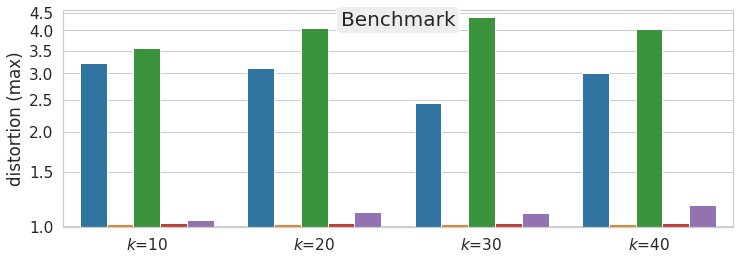

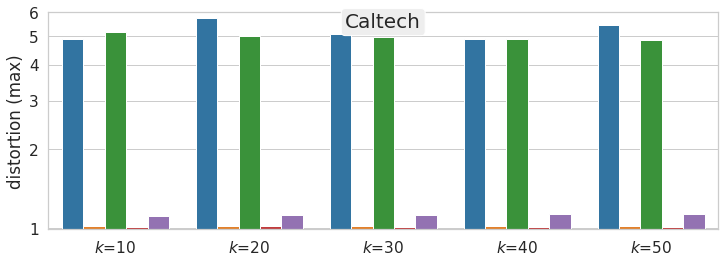

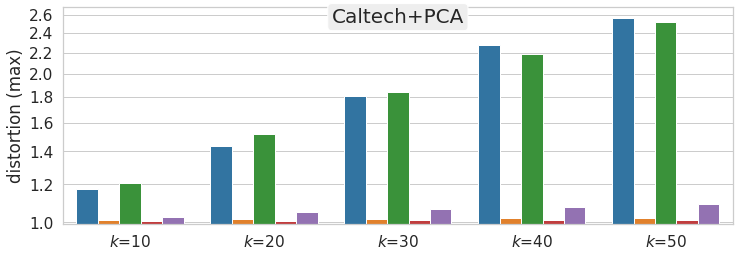

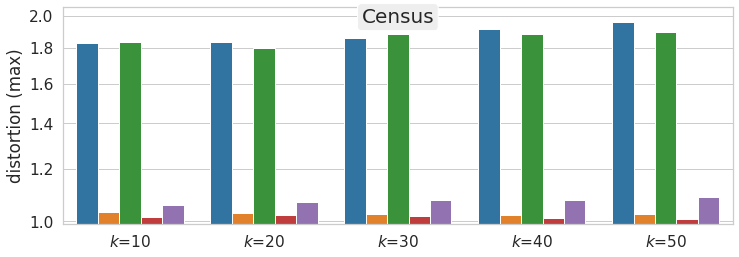

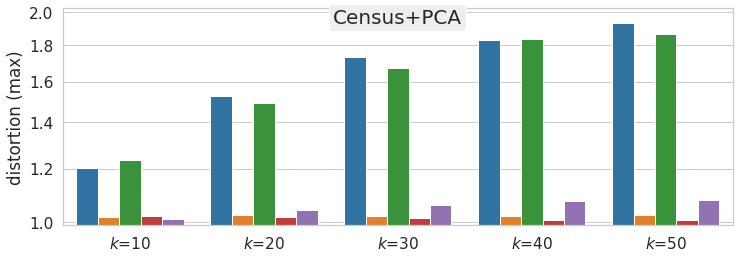

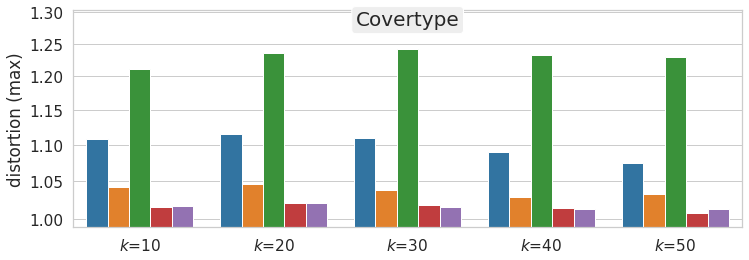

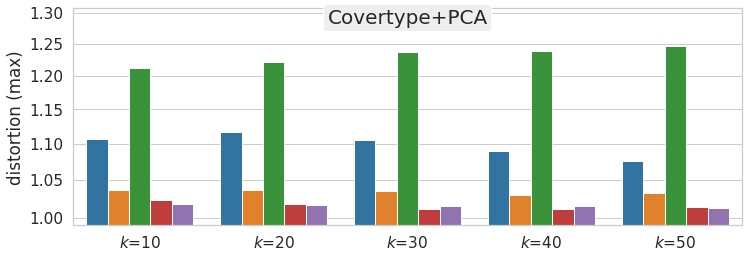

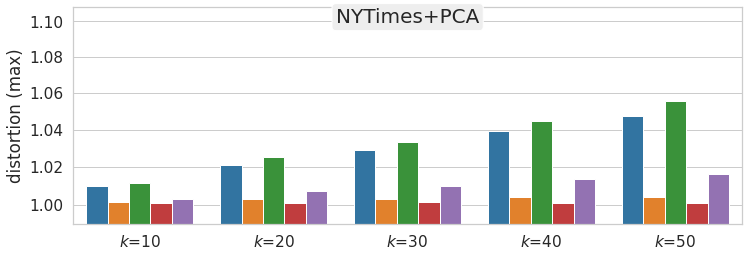

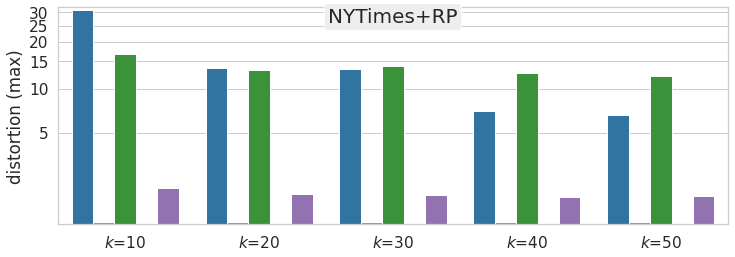

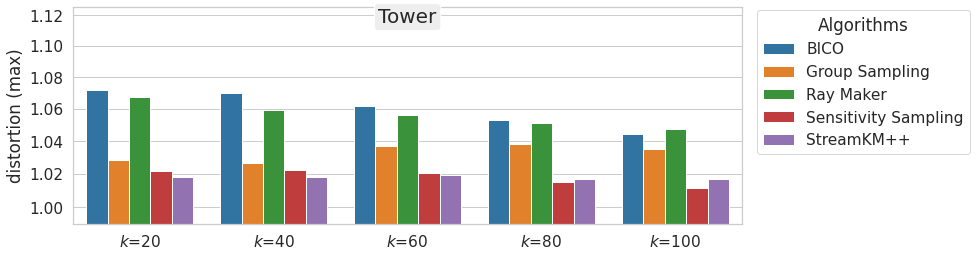

In [12]:
forward = lambda x: x**(1/10)
inverse = lambda x: x**10

with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion_max", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.9, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("distortion (max)")
        ax.set_xlabel("")
        ax.set_yscale('function', functions=(forward, inverse))
        ax.set_ylim(bottom=0.99)
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if is_tower:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        
        #fig.savefig(f"figures/distortions-{dataset}.pdf", bbox_inches="tight")

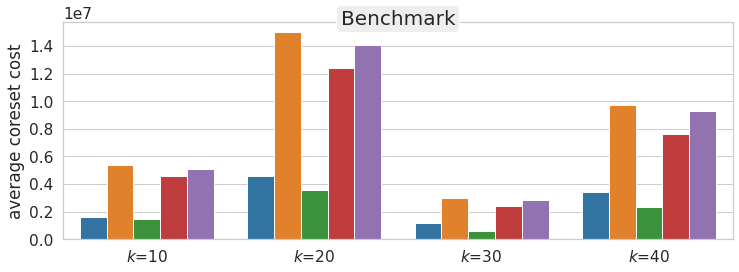

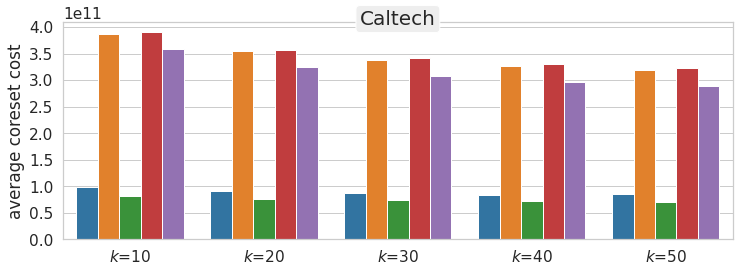

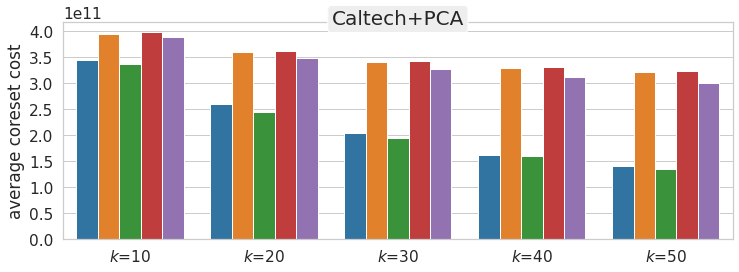

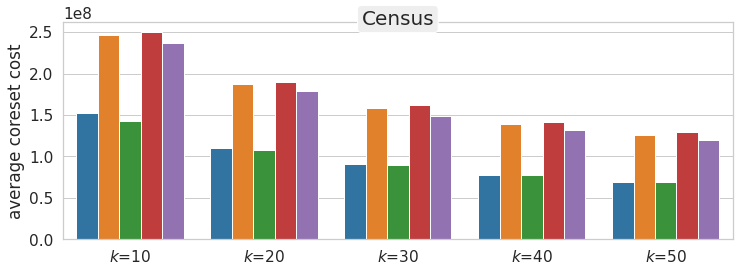

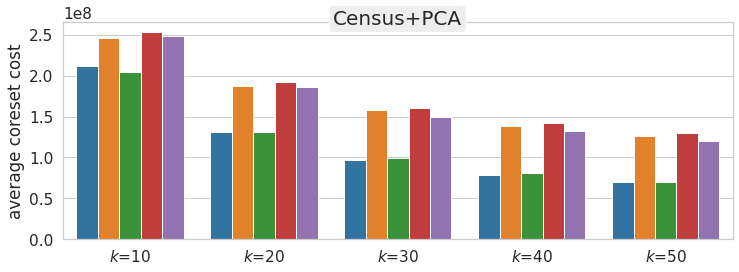

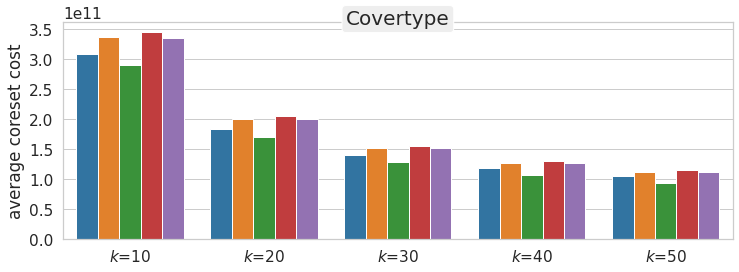

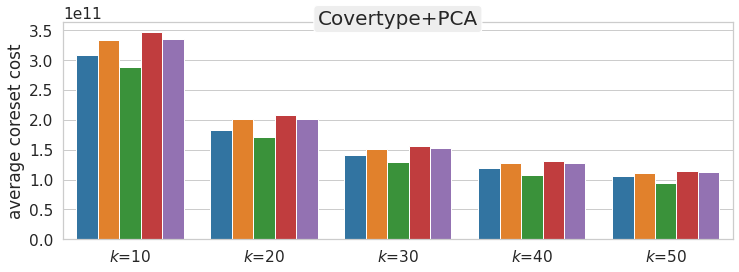

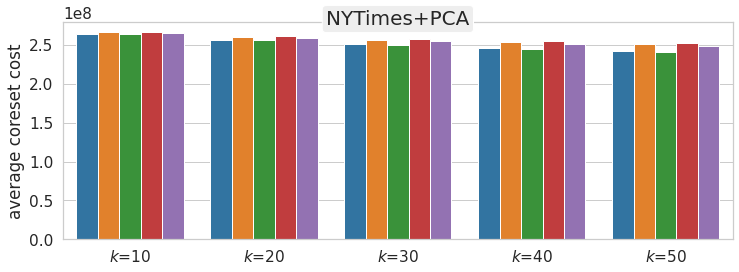

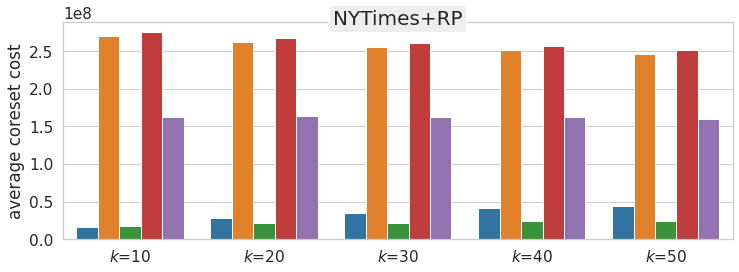

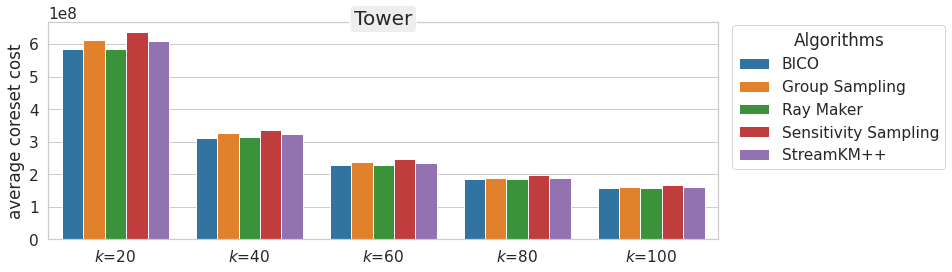

In [13]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.96, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average coreset cost")
        ax.set_xlabel("")
        if is_tower:
           ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
           ax.get_legend().remove()
        fig.savefig(f"figures/coreset-costs-{dataset}.pdf", bbox_inches="tight")

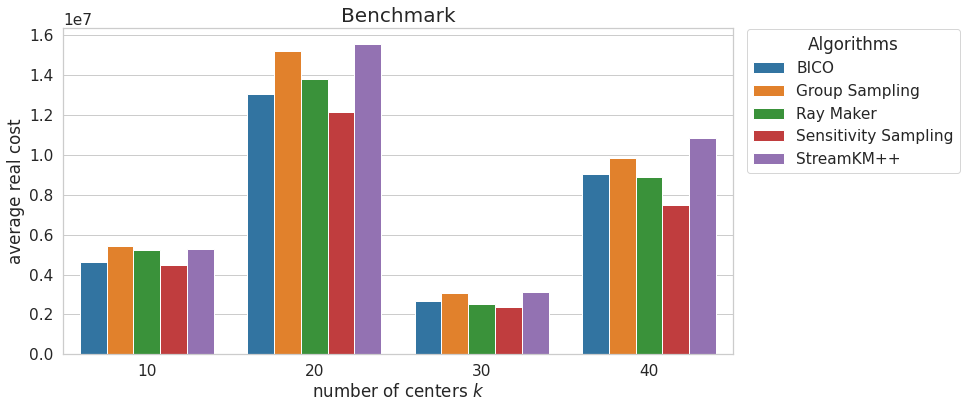

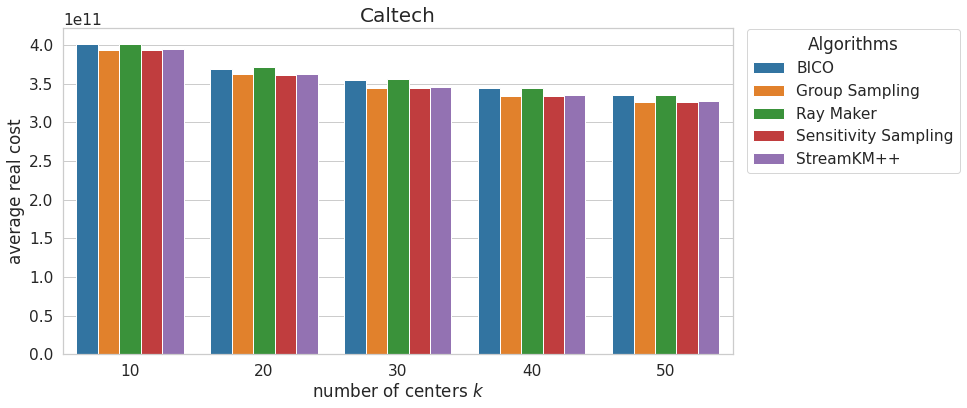

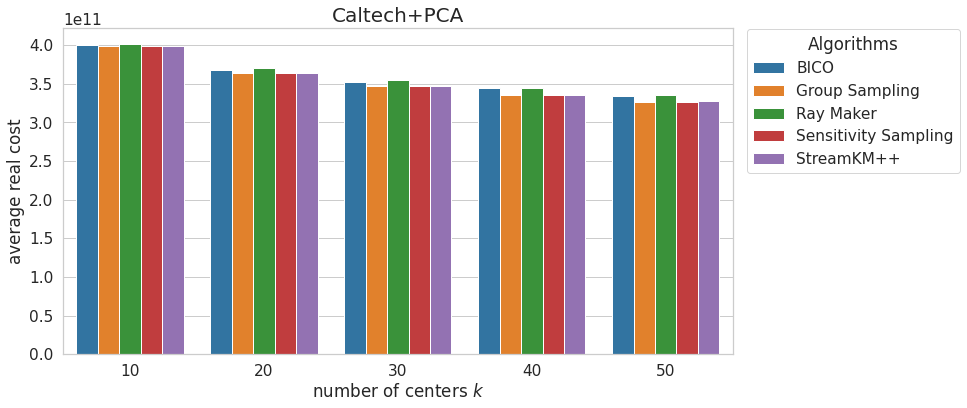

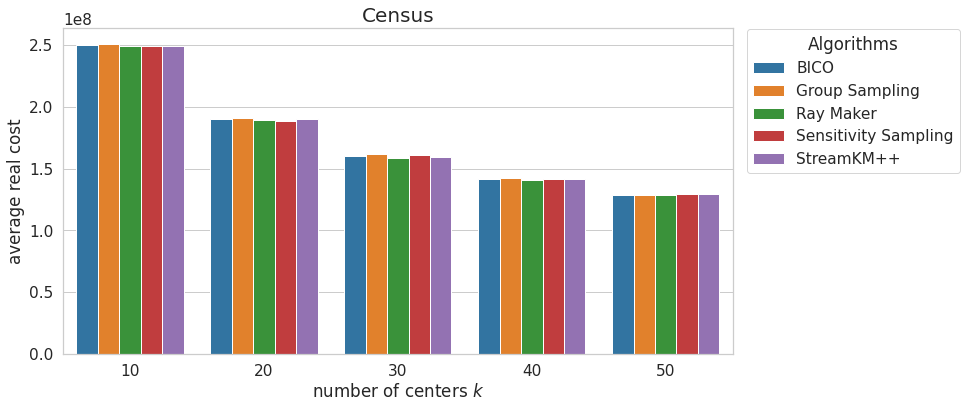

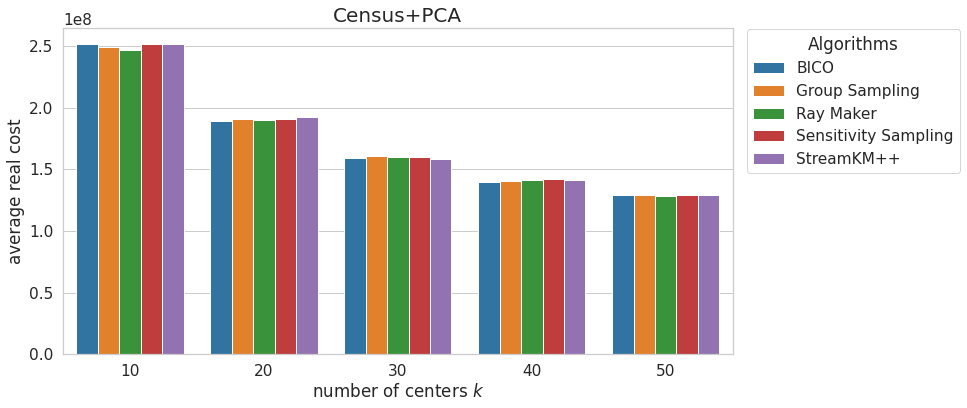

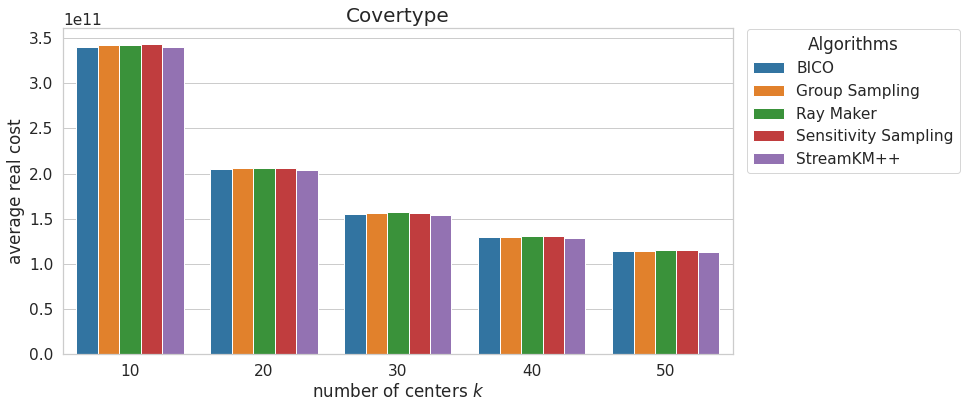

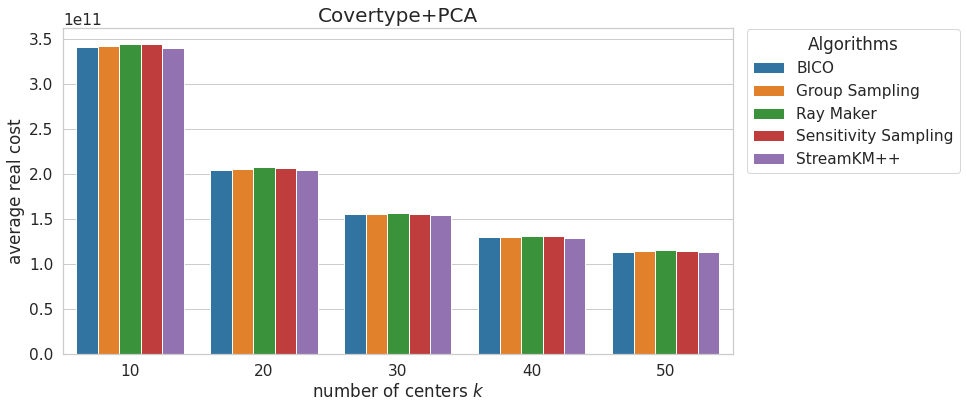

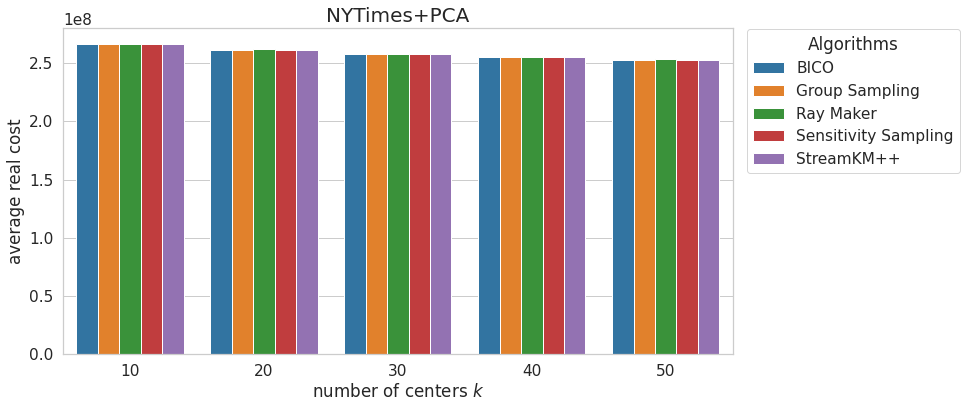

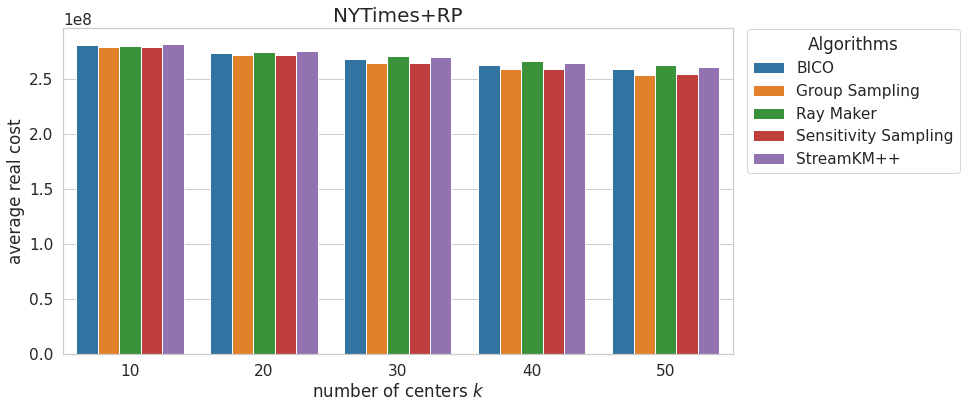

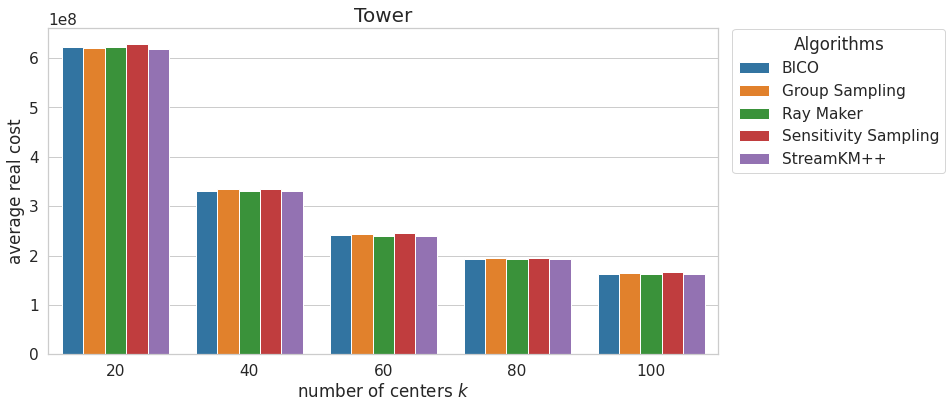

In [14]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=df_filtered, x="k", y="real_cost_mean", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20})
        ax.set_ylabel("average real cost")
        ax.set_xlabel("number of centers $k$")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        # fig.savefig(f"figures/{dataset}-real-costs.pdf", bbox_inches="tight")

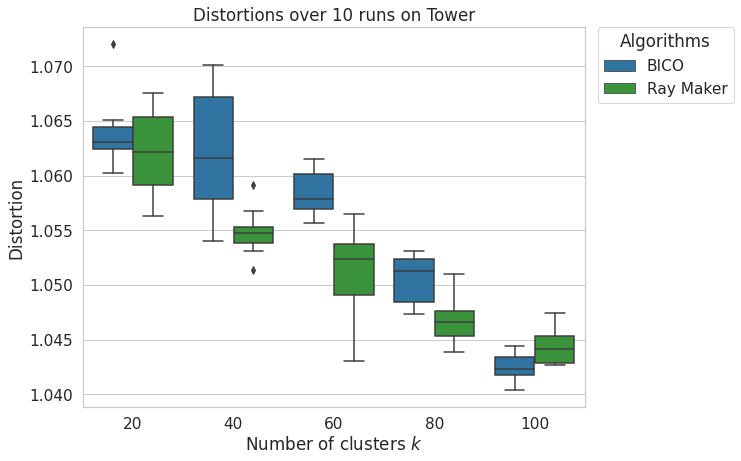

In [15]:
con_census = df_cost_data.dataset == 'Tower'
cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
cond_bico = df_cost_data.algorithm == 'BICO' 
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures/Tower-distortions-BICO-and-Ray-Maker.pdf", bbox_inches="tight")

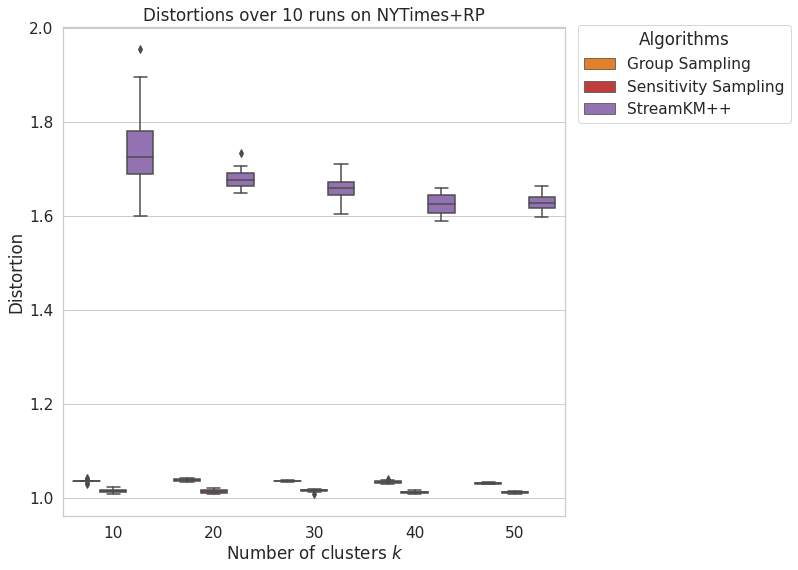

In [16]:
con_census = df_cost_data.dataset == 'NYTimes+RP'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures/NYTimes+RP-distortions-GS-SS-StreamKM.pdf", bbox_inches="tight")

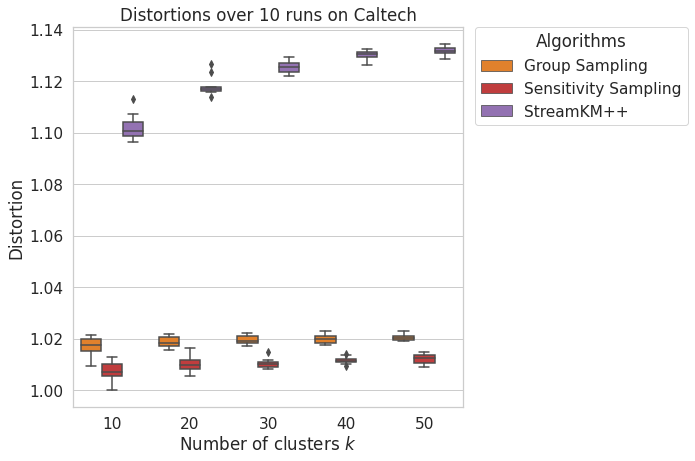

In [17]:
con_census = df_cost_data.dataset == 'Caltech'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by="algorithm", inplace=True)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}");
    # fig.savefig(f"figures/Caltech-distortions-GS-SS-StreamKM.pdf", bbox_inches="tight")

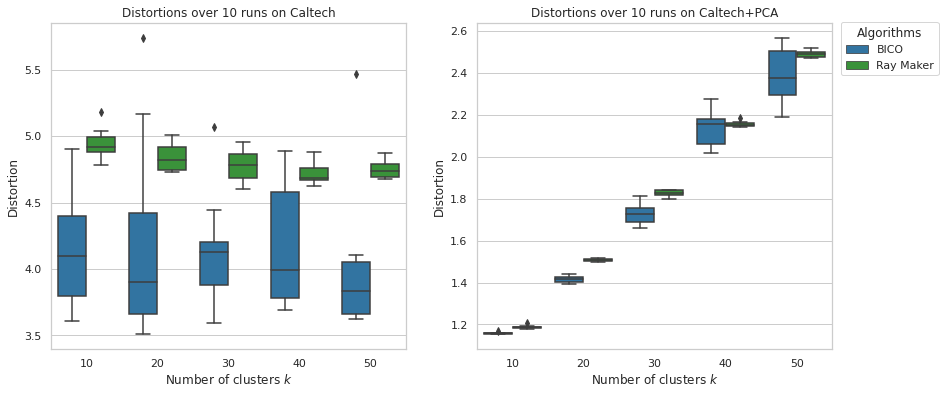

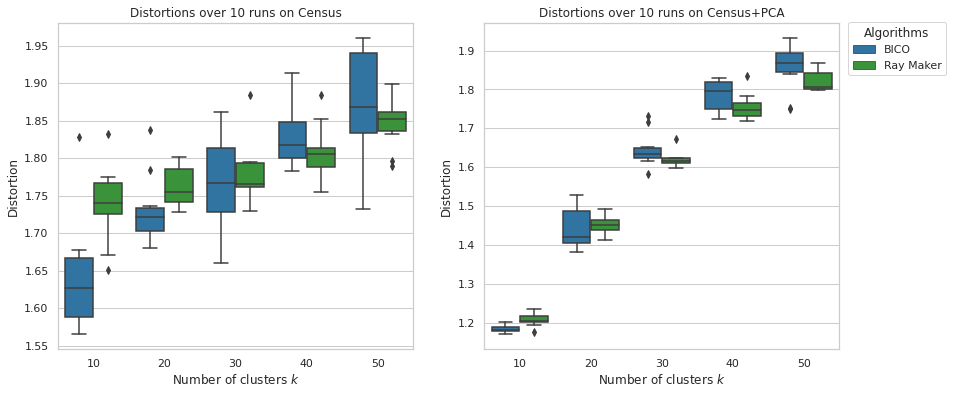

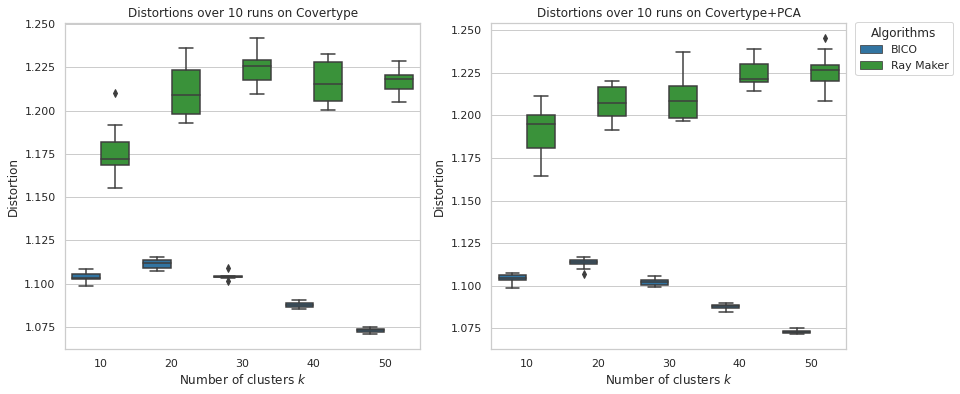

In [18]:
datasets = ["Caltech", "Census", "Covertype"]

for ds in datasets:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for i, dataset in enumerate([ds, f"{ds}+PCA"]):
        con_census = df_cost_data.dataset == dataset
        cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
        cond_bico = df_cost_data.algorithm == 'BICO' 
        cond_skm = df_cost_data.algorithm == 'StreamKM++' 
        df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
        df_filtered.sort_values(by="algorithm", inplace=True)

        ax = axes[i]
        sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
        ax.set_xlabel("Number of clusters $k$")
        ax.set_ylabel("Distortion")
        if i == 1:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        ax.set_title(f"Distortions over 10 runs on {dataset}");
    # fig.savefig(f"figures/{ds}-with-and-without-PCA-distortions-BICO-Ray-Maker.pdf", bbox_inches="tight")

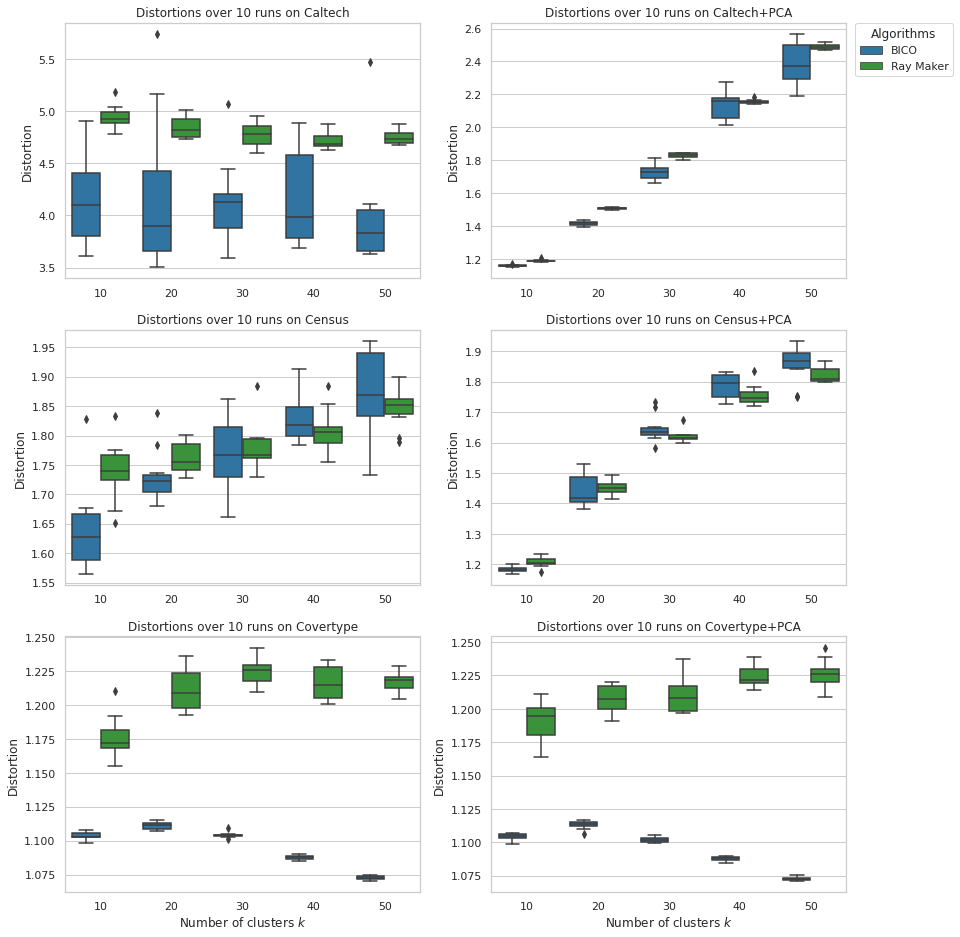

In [19]:
datasets = ["Caltech", "Caltech+PCA", "Census", "Census+PCA", "Covertype", "Covertype+PCA"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))

for i, dataset in enumerate(datasets):
    con_census = df_cost_data.dataset == dataset
    cond_ray_maker = df_cost_data.algorithm == 'Ray Maker' 
    cond_bico = df_cost_data.algorithm == 'BICO' 
    cond_skm = df_cost_data.algorithm == 'StreamKM++' 
    df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico)].copy()
    df_filtered.sort_values(by="algorithm", inplace=True)
    
    row_index = i // 2
    column_index = i % 2
    ax = axes[row_index, column_index]
    sns.boxplot(x="k", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("Number of clusters $k$" if i > 3 else "")
    ax.set_ylabel("Distortion")
    if i == 1:
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    else:
        ax.get_legend().remove()
    ax.set_title(f"Distortions over 10 runs on {dataset}");


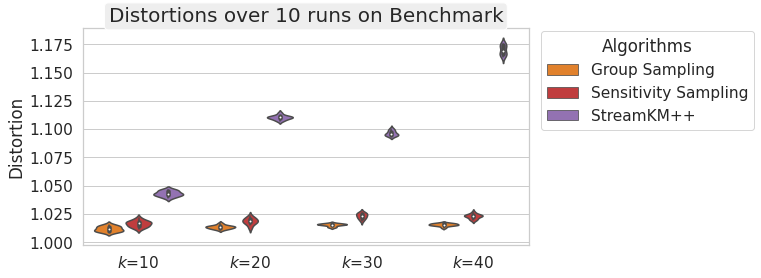

In [20]:
con_census = df_cost_data.dataset == 'Benchmark'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by=["algorithm", "k"], inplace=True)
df_filtered["k_formatted"] = "$k$=" + df_filtered["k"].astype(str)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(x="k_formatted", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}",
                fontdict={"size": 20}, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"));
    
    # fig.savefig(f"figures/violin-Benchmark-GS-SS-StreamKM.pdf", bbox_inches="tight")

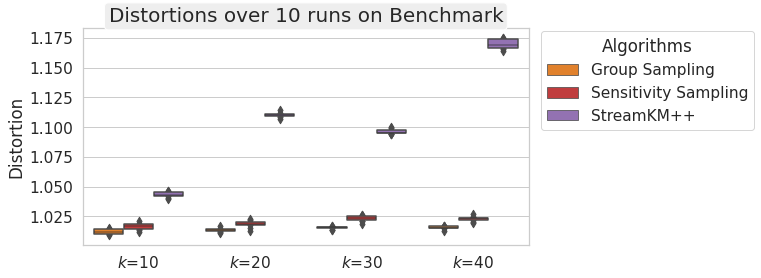

In [21]:
con_census = df_cost_data.dataset == 'Benchmark'
cond_ray_maker = df_cost_data.algorithm == 'Sensitivity Sampling'
cond_bico = df_cost_data.algorithm == 'Group Sampling'
cond_skm = df_cost_data.algorithm == 'StreamKM++' 
df_filtered = df_cost_data[con_census & (cond_ray_maker | cond_bico | cond_skm)].copy()
df_filtered.sort_values(by=["algorithm", "k"], inplace=True)
df_filtered["k_formatted"] = "$k$=" + df_filtered["k"].astype(str)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxenplot(x="k_formatted", y="distortion", hue="algorithm", data=df_filtered, palette=algorithm_colors, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Distortion")
    ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
    ax.set_title(f"Distortions over 10 runs on {df_filtered.dataset.unique()[0]}",
                fontdict={"size": 20}, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"));
    
    # fig.savefig(f"figures/boxplot-Benchmark-GS-SS-StreamKM.pdf", bbox_inches="tight")